# 2D instance segmentation example with RDCNet

This notebook illustrates how to train a RDCNet and predict nuclear segmentation in U2OS cells on a dataset publicly available as [BBBC039](https://bbbc.broadinstitute.org/bbbc/BBBC039) from the Broad Bioimage Benchmark Collection [[Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083)]

Note that the aim of this notebook is to provide a minimum working example and that in a real use case scenario, extra steps should be taken, e.g. train|valid|test split, data augmentation, etc.

In [1]:
import os
import numpy as np
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["image.interpolation"] = None

OUTDIR = 'BBBC039_outputs'
os.makedirs(OUTDIR, exist_ok=True)

# define labels colormap
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
label_cmap = plt.cm.colors.ListedColormap(np.concatenate([[[0.,0.,0.,1.]],plt.cm.jet(vals)]))

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Download the data

In [3]:
import requests
import io
import zipfile

def download_extract_zip(url, outdir):
    """
    Download a ZIP file and extract its contents in memory
    yields (filename, file-like object) pairs
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        for zipinfo in thezip.infolist():
            thezip.extract(member=zipinfo, path=outdir)

if not os.path.exists(os.path.join(OUTDIR,'masks')):
    download_extract_zip('https://data.broadinstitute.org/bbbc/BBBC039/masks.zip', OUTDIR)
    
if not os.path.exists(os.path.join(OUTDIR, 'images')):
    download_extract_zip('https://data.broadinstitute.org/bbbc/BBBC039/images.zip', OUTDIR)

# Train a RDCNet model

## Create a tensorflow dataset

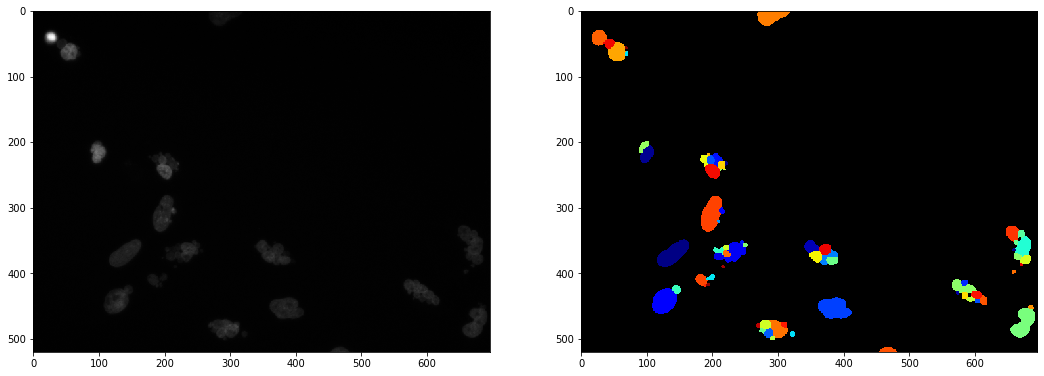

In [4]:
from skimage.io import imread
from skimage.morphology import label

def load_sample(seg_path):
    seg_path = seg_path.numpy().decode()
    
    segm = imread(seg_path)
    # keep first channel
    segm = segm[...,0]
    # cleanup labels
    segm = label(segm).astype(np.int32)
    
    # get path to input image maatching the segmentation groundtruth
    raw_path = seg_path.replace('masks', 'images').replace('.png', '.tif')
    raw = imread(raw_path).astype(np.float32)
    
    # standardize intensitites
    raw -= raw.mean()
    raw /= raw.std()
    return [raw, segm]

dataset = tf.data.Dataset.list_files(os.path.join(OUTDIR,'masks/*.png'))
dataset = dataset.map(lambda x: tf.py_function(func=load_sample, inp=[x], Tout=[tf.float32, tf.int32]))

#inspect the first sample
raw, segm = next(dataset.as_numpy_iterator())
fig,axs = plt.subplots(1,2,figsize=(18,9))
axs[0].imshow(raw, cmap='Greys_r')
axs[1].imshow(segm, cmap=label_cmap)
plt.show()

## Build the model

In [5]:
from rdcnet.models.rdcnet import GenericRDCnetBase
from rdcnet.models.heads import add_instance_seg_heads

model = GenericRDCnetBase(input_shape=(None,None,1),
                              downsampling_factor=6,
                              n_downsampling_channels=8,
                              n_output_channels=4,
                              n_groups=4,
                              dilation_rates=(1, 2, 4, 8, 16),
                              channels_per_group=32,
                              n_steps=6,
                              dropout=0.1)

model = add_instance_seg_heads(model, n_classes=2)

## Train

In [6]:
def sample_to_training_inputs(raw, segm):
    '''Formats the sample as input|target pairs'''
    
    # tensor shape was lost in tf.py_function
    raw.set_shape((520, 696))
    segm.set_shape((520, 696))
    
    foreground = tf.minimum(segm, 1)
    foreground_hot = tf.one_hot(foreground, depth=2)
    
    # add channel dim
    raw = raw[...,None]
    segm = segm[...,None]
    
    return raw, {'embeddings':segm, 'semantic_class':foreground_hot}

In [7]:
from rdcnet.losses.jaccard_loss import JaccardLoss
from rdcnet.losses.embedding_loss import InstanceMeanIoUEmbeddingLoss
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger

EPOCHS = 100
LEARNING_RATE = 0.001
BATCH_SIZE = 2
MARGIN = 10

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss={'embeddings':InstanceMeanIoUEmbeddingLoss(margin=MARGIN),
                    'semantic_class':JaccardLoss()})

trainset = dataset.map(sample_to_training_inputs)\
                  .cache()\
                  .shuffle(100)\
                  .batch(BATCH_SIZE)

callbacks = [CSVLogger(os.path.join(OUTDIR, 'trained_model/training.log'),separator=','),
             ModelCheckpoint(os.path.join(OUTDIR, 'trained_model/checkpoints/weights_best'),
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='loss')]

os.makedirs(os.path.join(OUTDIR, 'trained_model'), exist_ok=True)
model.fit(trainset,
          validation_data=None,
          epochs=EPOCHS,
          callbacks=callbacks)

model.save(os.path.join(OUTDIR, 'trained_model'))

Epoch 1/100
Instructions for updating:
Use fn_output_signature instead
100/100 [==============================] - 18s 182ms/step - loss: 0.4644 - embeddings_loss: 0.2841 - semantic_class_loss: 0.1802
Epoch 2/100
100/100 [==============================] - 16s 161ms/step - loss: 0.2768 - embeddings_loss: 0.2038 - semantic_class_loss: 0.0731
Epoch 3/100
100/100 [==============================] - 16s 162ms/step - loss: 0.2383 - embeddings_loss: 0.1743 - semantic_class_loss: 0.0640
Epoch 4/100
100/100 [==============================] - 16s 163ms/step - loss: 0.2143 - embeddings_loss: 0.1538 - semantic_class_loss: 0.0605
Epoch 5/100
100/100 [==============================] - 16s 163ms/step - loss: 0.2026 - embeddings_loss: 0.1447 - semantic_class_loss: 0.0578
Epoch 6/100
100/100 [==============================] - 16s 164ms/step - loss: 0.1928 - embeddings_loss: 0.1341 - semantic_class_loss: 0.0587
Epoch 7/100
100/100 [==============================] - 16s 163ms/step - loss: 0.1835 - embeddin

100/100 [==============================] - 16s 164ms/step - loss: 0.1069 - embeddings_loss: 0.0601 - semantic_class_loss: 0.0468
Epoch 57/100
100/100 [==============================] - 16s 164ms/step - loss: 0.1068 - embeddings_loss: 0.0601 - semantic_class_loss: 0.0467
Epoch 58/100
100/100 [==============================] - 16s 164ms/step - loss: 0.1052 - embeddings_loss: 0.0591 - semantic_class_loss: 0.0460
Epoch 59/100
100/100 [==============================] - 16s 164ms/step - loss: 0.1077 - embeddings_loss: 0.0614 - semantic_class_loss: 0.0463
Epoch 60/100
100/100 [==============================] - 16s 164ms/step - loss: 0.1053 - embeddings_loss: 0.0589 - semantic_class_loss: 0.0463
Epoch 61/100
100/100 [==============================] - 16s 164ms/step - loss: 0.1082 - embeddings_loss: 0.0614 - semantic_class_loss: 0.0468
Epoch 62/100
100/100 [==============================] - 16s 163ms/step - loss: 0.1022 - embeddings_loss: 0.0567 - semantic_class_loss: 0.0456
Epoch 63/100
100/10

## Plot the training loss vs epochs

<AxesSubplot:>

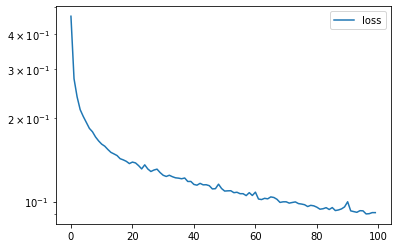

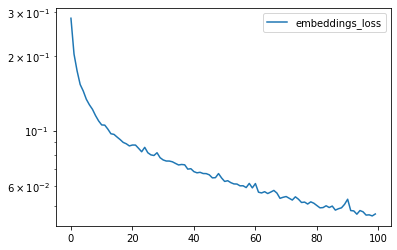

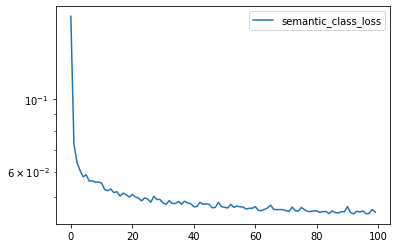

In [8]:
import pandas as pd

data = pd.read_csv(os.path.join(OUTDIR, 'trained_model/training.log'))
data[['loss']].plot(logy=True)
data[['embeddings_loss']].plot(logy=True)
data[['semantic_class_loss']].plot(logy=True)

# Apply the trained model

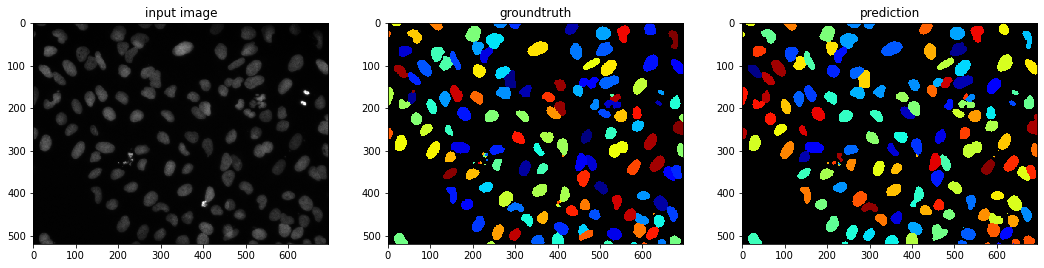

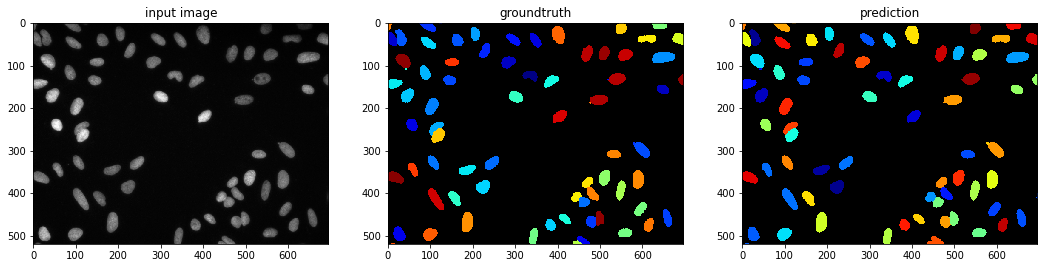

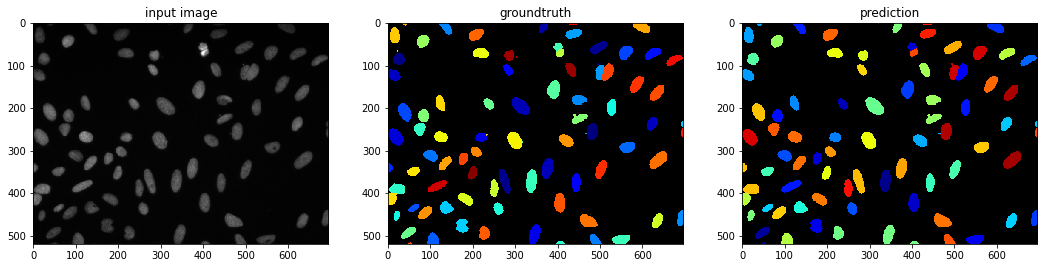

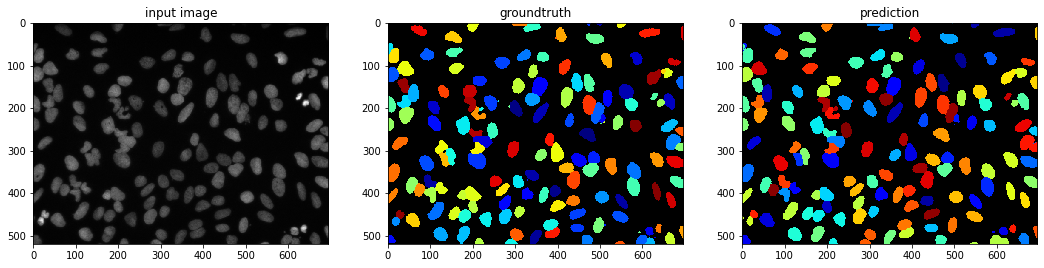

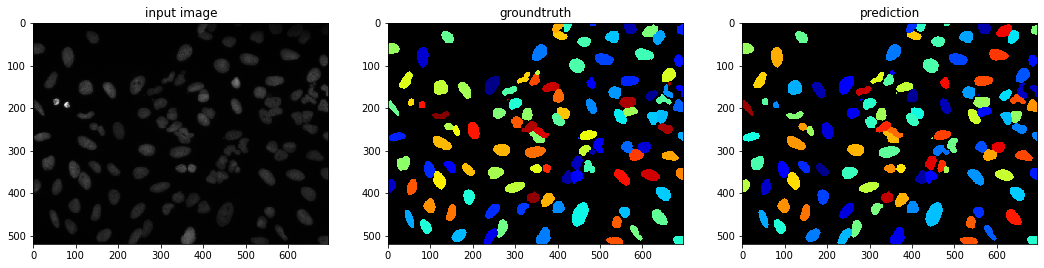

In [9]:
from rdcnet.postprocessing.voting import embeddings_to_labels

reloaded_model = tf.keras.models.load_model(os.path.join(OUTDIR, 'trained_model'), compile=False)

for raw, segm in list(dataset.as_numpy_iterator())[:5]:
    
    # add batch and channel dimensions and predict
    embeddings, classes = reloaded_model.predict_on_batch(raw[None,...,None])
    
    # convert embeddings to labels
    fg_mask = np.argmax(classes, axis=-1)[0]
    embeddings = embeddings[0]
    labels = embeddings_to_labels(embeddings,
                                  fg_mask,
                                  peak_min_distance=20,
                                  min_count=5)
    
    # plot the result
    fig,axs = plt.subplots(1,3,figsize=(18,6))
    axs[0].imshow(raw, cmap='Greys_r')
    axs[1].imshow(segm, cmap=label_cmap)
    axs[2].imshow(labels, cmap=label_cmap)
    axs[0].set_title('input image')
    axs[1].set_title('groundtruth')
    axs[2].set_title('prediction')
    plt.show()